# Tail Latency Curve

## 1. Copy latency hdr files to this machine

```console
$ rsync -azR --no-i-r -h --info=progress2 squirrel.moma:/home/wenyuz/./MMTk-Dev/evaluation/results/log/lxr-latency-bear-2023-12-21-Thu-114935 /home/wenyuz
```

## 2. Imports and configs

In [1]:
from hdrh.histogram import HdrHistogram
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from enum import Enum
import matplotlib as mpl
from pathlib import Path

In [2]:
class LatencyType(Enum):
    METERED = 'metered'
    SIMPLE = 'simple'

LATENCY_TYPE = LatencyType.METERED

RUNIDS = [
    'lxr-latency-boar-2023-12-21-Thu-115051',
]

SAVE_FILE = 'pdf'
# SAVE_FILE = 'jpg'
# SAVE_FILE = None

MAX_INVOCATIONS = 40
MIN_LATENCY_USEC = 1
MAX_LATENCY_USEC = 1000 * 1000 # 1 sec
LATENCY_SIGNIFICANT_DIGITS = 5

LABEL_FONT_SIZE = 60
LEGEND_FONT_SIZE = 60
TICK_FONT_SIZE = 50

In [3]:
# plt.rcParams["font.family"] = "Linux Biolinum"

def load_latency_data(bench: str, latency_type: LatencyType, folder: Path):
    folders = list(folder.glob(f"{bench}.*"))
    print(f"[{bench}] Loading histograms from {len(folders)} folders ...")
    histograms: dict[str, list[HdrHistogram]] = {}
    for i, child in enumerate(folders, start=1):
        if not child.is_dir(): continue
        parts = child.name.split(".")
        gc = parts[4]
        if gc == "Z" and parts[6] == "zgc_gen": gc = "GenZ"
        bench = parts[0]
        for hdr in child.glob(f"*-{latency_type.value}-4.hdr"):
            parts = hdr.stem.split("-")
            with hdr.open("r") as fd:
                hist_raw = fd.read().split(",")[3]
                hist = HdrHistogram.decode(hist_raw)
                if gc not in histograms: histograms[gc] = []
                histograms[gc].append(hist)
    return histograms

def load_data_and_plot(bench: str, save = SAVE_FILE, latency_type: LatencyType = LATENCY_TYPE, legend: str | bool = True, max_percentile='99.999'):
    print(f'[{bench}] Loading ...')
    # Load data
    histograms = {}
    for runid in RUNIDS:
        hists = load_latency_data(bench, latency_type, Path(f'/home/wenyuz/MMTk-Dev/evaluation/results/log/{runid}'))
        for gc, h in hists.items():
            if gc not in histograms: histograms[gc] = []
            histograms[gc].extend(h)
    # Process data
    histograms_len = sum([len(x) for x in histograms.values()])
    print(f'[{bench}] Processing {histograms_len} histograms ...')
    percentile_list = []
    for gc, hists in histograms.items():
        for j, histogram in enumerate(hists):
            for i in histogram.get_percentile_iterator(5):
                percentile_list.append({"GC": gc, "inv": j, "value": i.value_iterated_to, "percentile": i.percentile_level_iterated_to / 100})
    percentile_df = pd.DataFrame(percentile_list)
    print(percentile_df)
    percentile_df["other"] = 1 / (1 - percentile_df["percentile"])
    # Plot curves
    print(f'[{bench}] Plotting ...')
    fig, ax = plt.subplots(1,1,figsize=(16,12))
    # fig.suptitle(f'{bench} {latency_type} latency')
    sns.color_palette()
    # colors = ['green', 'blue', 'orange', 'red'][:len(gcs)]
    # print(f'{gcs} {colors}')
    sns.lineplot(data=percentile_df, x="other", y="value", hue="GC")
    # sns.lineplot(data=percentile_df, x="other", y="value", hue="GC")
    ax.set_xscale('log')
    ax.set_xlabel('Percentile', fontsize=LABEL_FONT_SIZE, labelpad=12)
    ax.set_ylabel('Latency (msec)', fontsize=LABEL_FONT_SIZE, labelpad=12)
    labels = ['0', '90', '99', '99.9', '99.99', '99.999', '99.9999']
    ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000][:labels.index(max_percentile) + 1])
    ax.set_xticklabels(labels[:labels.index(max_percentile) + 1], fontsize=TICK_FONT_SIZE)
    # ax.set_xticks([1, 10, 100, 1000, 10000, 100000])
    # ax.set_xticklabels(['0', '90', '99', '99.9', '99.99', '99.999'], fontsize=TICK_FONT_SIZE)
    plt.yticks(fontsize=TICK_FONT_SIZE)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{int(x / 1000)}'.format(x)))
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,1,3,2]
    if legend == False:
        plt.legend([], [], frameon=False)
    elif legend == True:
        plt.legend([handles[i] for i in order], [labels[i] for i in order],  fontsize=LEGEND_FONT_SIZE)
    else:
        plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=LEGEND_FONT_SIZE, loc=legend)
    plt.tight_layout()

    if save is not None:
        print(f'[{bench}] Save to latency-{bench}.{save}')
        plt.savefig(f'latency-{bench}.{save}', bbox_inches='tight')

[lusearch] Loading ...
[lusearch] Loading histograms from 122 folders ...
[lusearch] Processing 118 histograms ...
        GC  inv  value  percentile
0      lxr    0      5    0.000000
1      lxr    0     29    0.100000
2      lxr    0     46    0.190000
3      lxr    0    168    0.271000
4      lxr    0    589    0.343900
...    ...  ...    ...         ...
14981   g1   37  47853    0.999997
14982   g1   37  47853    0.999998
14983   g1   37  47853    0.999998
14984   g1   37  47905    0.999998
14985   g1   37  47905    1.000000

[14986 rows x 4 columns]
[lusearch] Plotting ...


IndexError: list index out of range

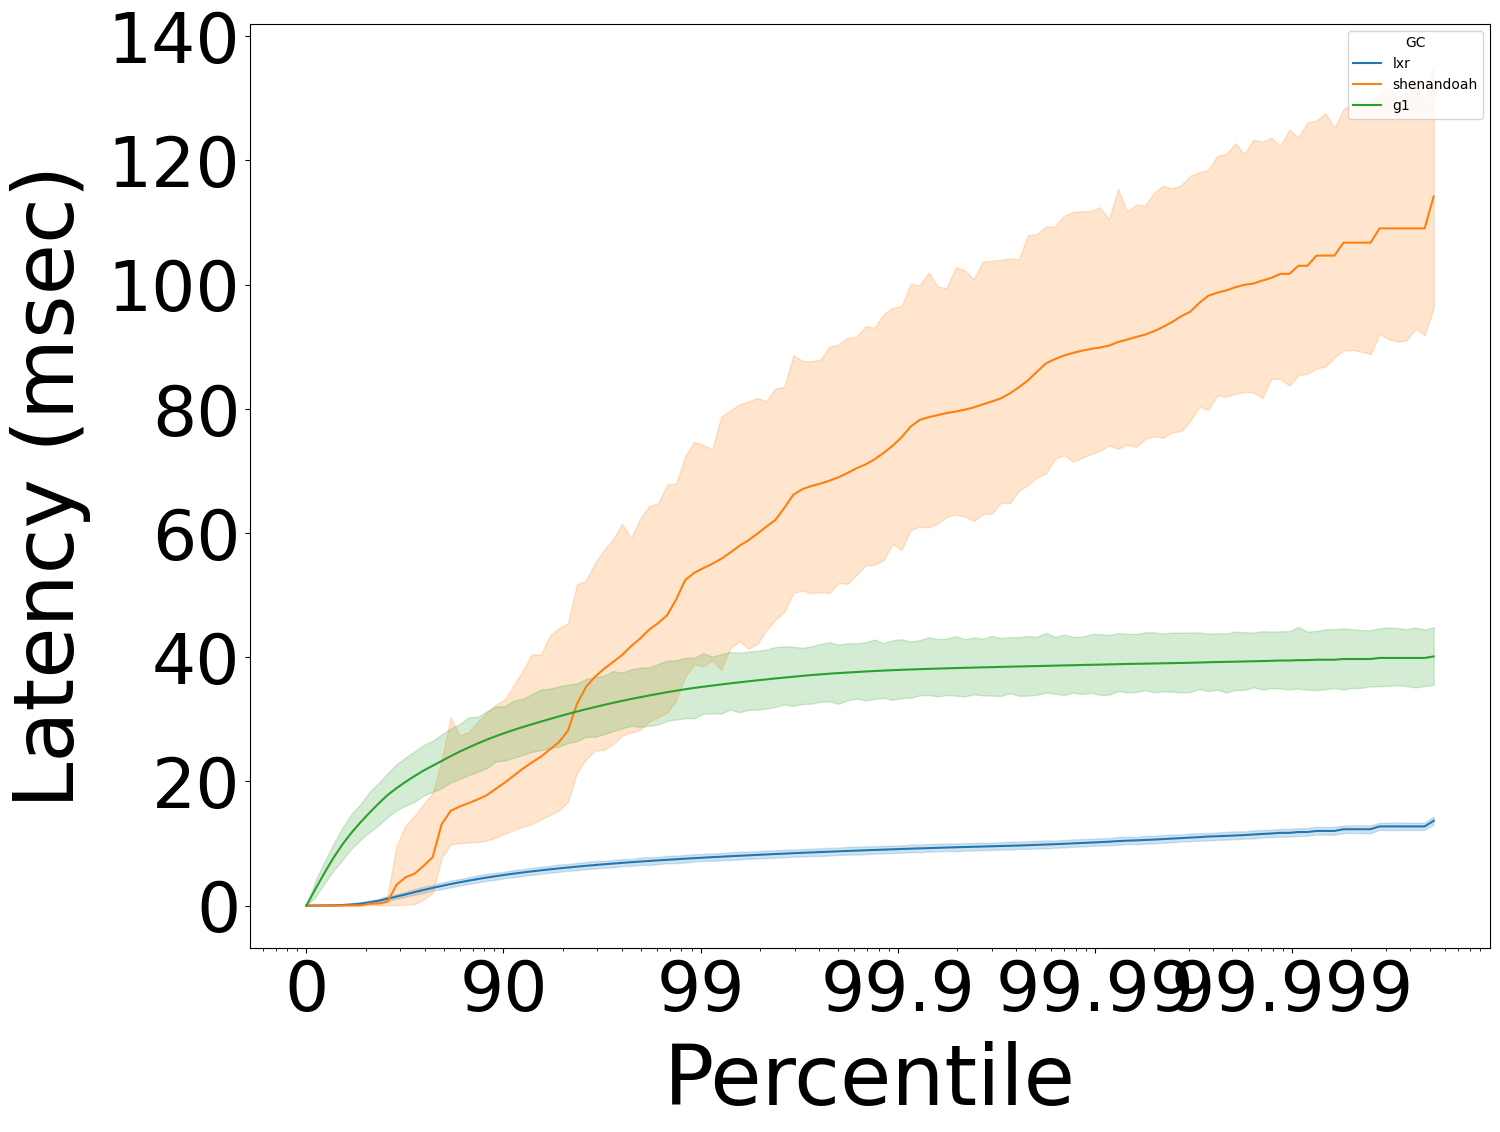

In [4]:
load_data_and_plot(bench='lusearch', legend='upper left')

[cassandra] Loading ...
[cassandra] Loading histograms from 124 folders ...
[cassandra] Processing 120 histograms ...
               GC  inv  value  percentile
0             lxr    0     73    0.000000
1             lxr    0    183    0.100000
2             lxr    0    197    0.190000
3             lxr    0    208    0.271000
4             lxr    0    217    0.343900
...           ...  ...    ...         ...
14149  shenandoah   39  14104    0.999993
14150  shenandoah   39  14104    0.999994
14151  shenandoah   39  14104    0.999995
14152  shenandoah   39  14119    0.999995
14153  shenandoah   39  14119    1.000000

[14154 rows x 4 columns]
[cassandra] Plotting ...


IndexError: list index out of range

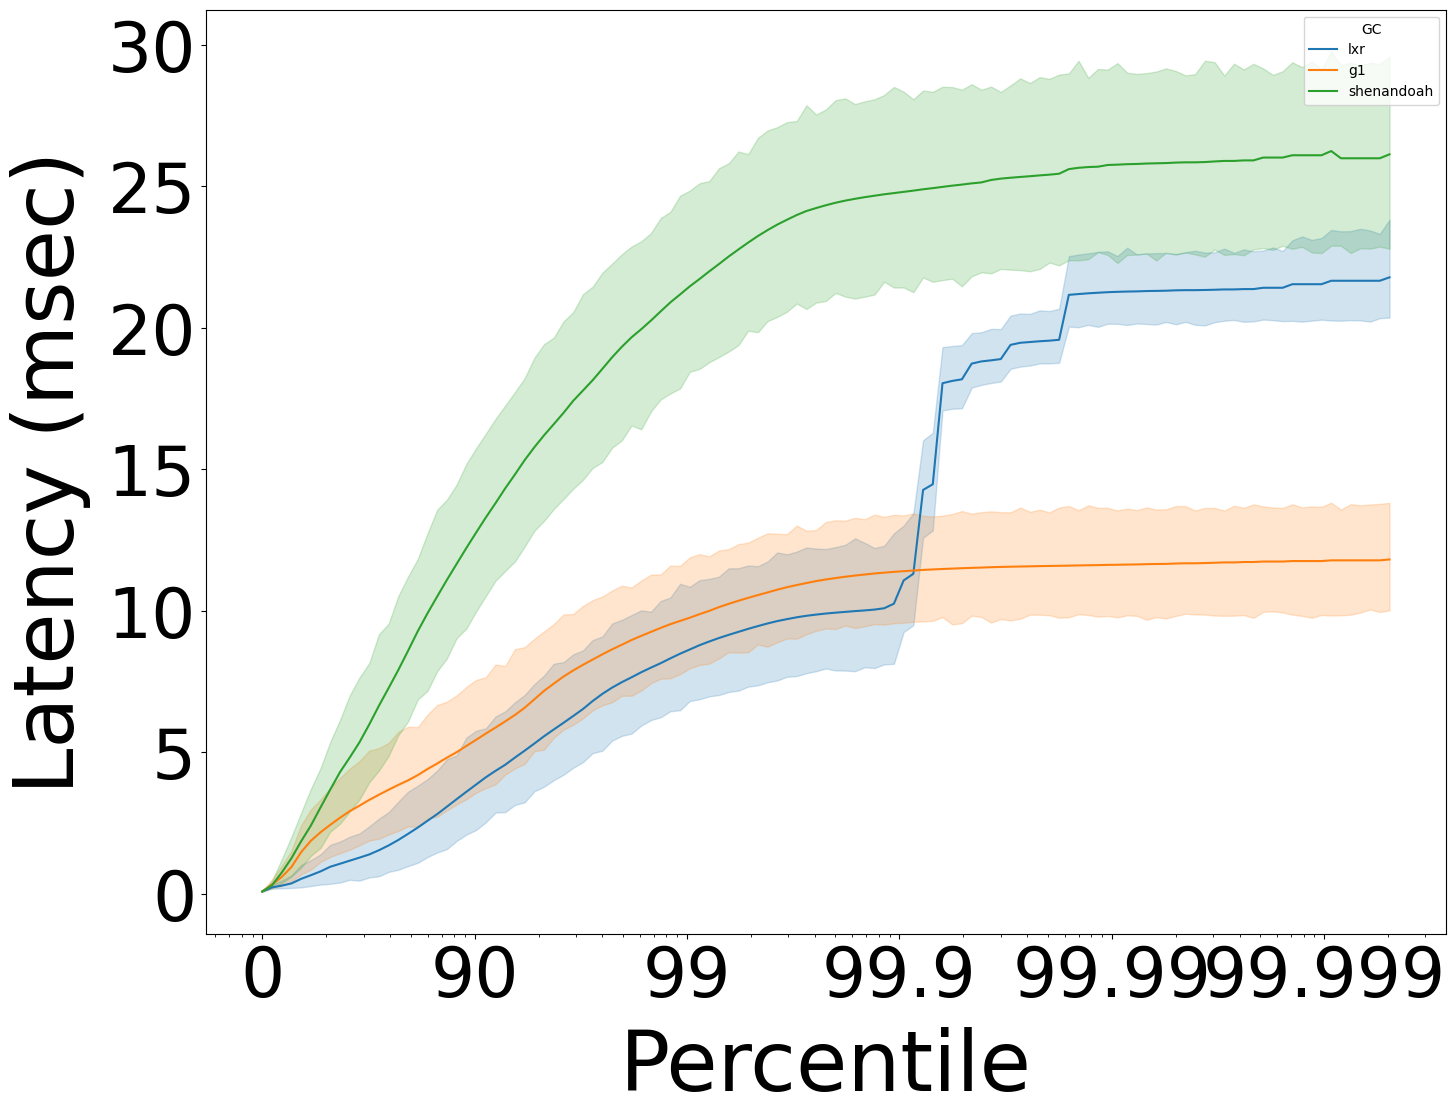

In [5]:
load_data_and_plot(bench='cassandra', legend='upper left')

[h2] Loading ...
[h2] Loading histograms from 164 folders ...
[h2] Processing 160 histograms ...
        GC  inv  value  percentile
0      lxr    0      0    0.000000
1      lxr    0     25    0.100000
2      lxr    0     33    0.190000
3      lxr    0     40    0.271000
4      lxr    0    113    0.343900
...    ...  ...    ...         ...
17915   g1   39  26881    0.999987
17916   g1   39  26881    0.999989
17917   g1   39  26881    0.999990
17918   g1   39  27312    0.999991
17919   g1   39  27312    1.000000

[17920 rows x 4 columns]
[h2] Plotting ...
[h2] Save to latency-h2.pdf


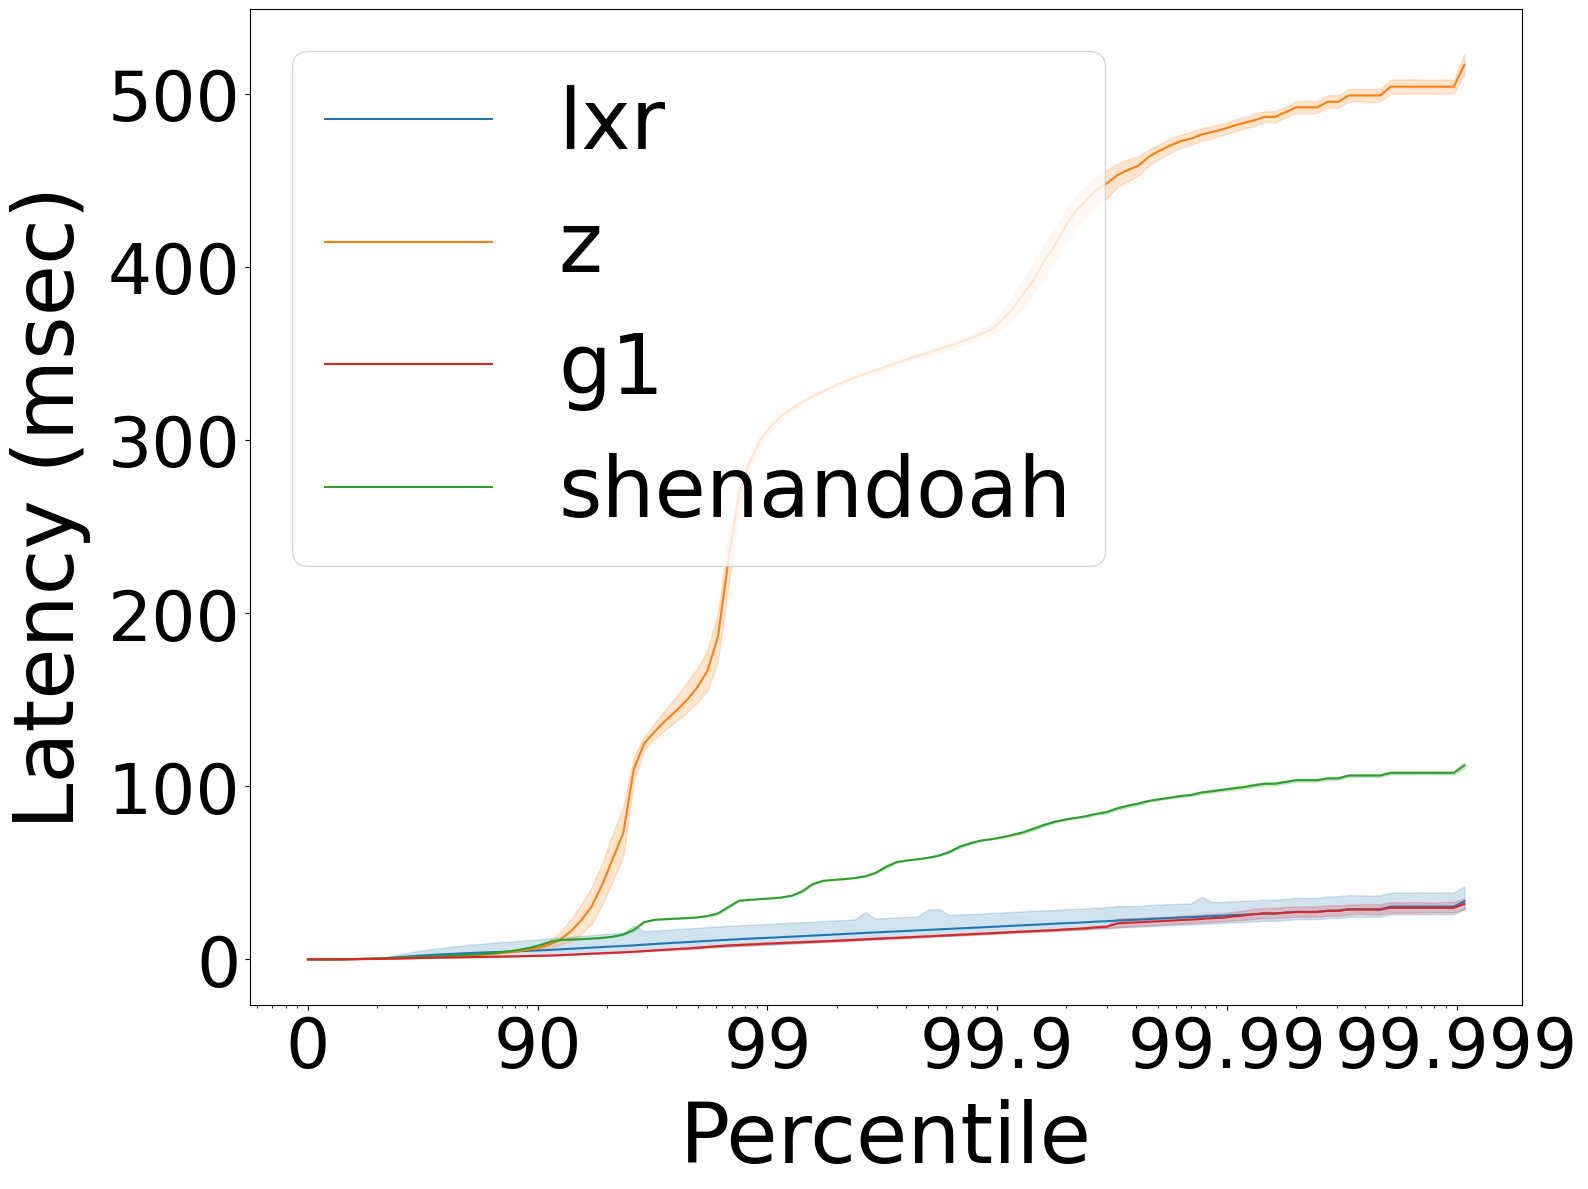

In [6]:
load_data_and_plot(bench='h2', legend='upper left')

[spring] Loading ...
[spring] Loading histograms from 124 folders ...
[spring] Processing 120 histograms ...
               GC  inv   value  percentile
0             lxr    0     327    0.000000
1             lxr    0    1773    0.100000
2             lxr    0    2678    0.190000
3             lxr    0    4211    0.271000
4             lxr    0    6735    0.343900
...           ...  ...     ...         ...
10555  shenandoah   39  453039    0.999841
10556  shenandoah   39  453039    0.999857
10557  shenandoah   39  453039    0.999871
10558  shenandoah   39  464735    0.999884
10559  shenandoah   39  464735    1.000000

[10560 rows x 4 columns]
[spring] Plotting ...


IndexError: list index out of range

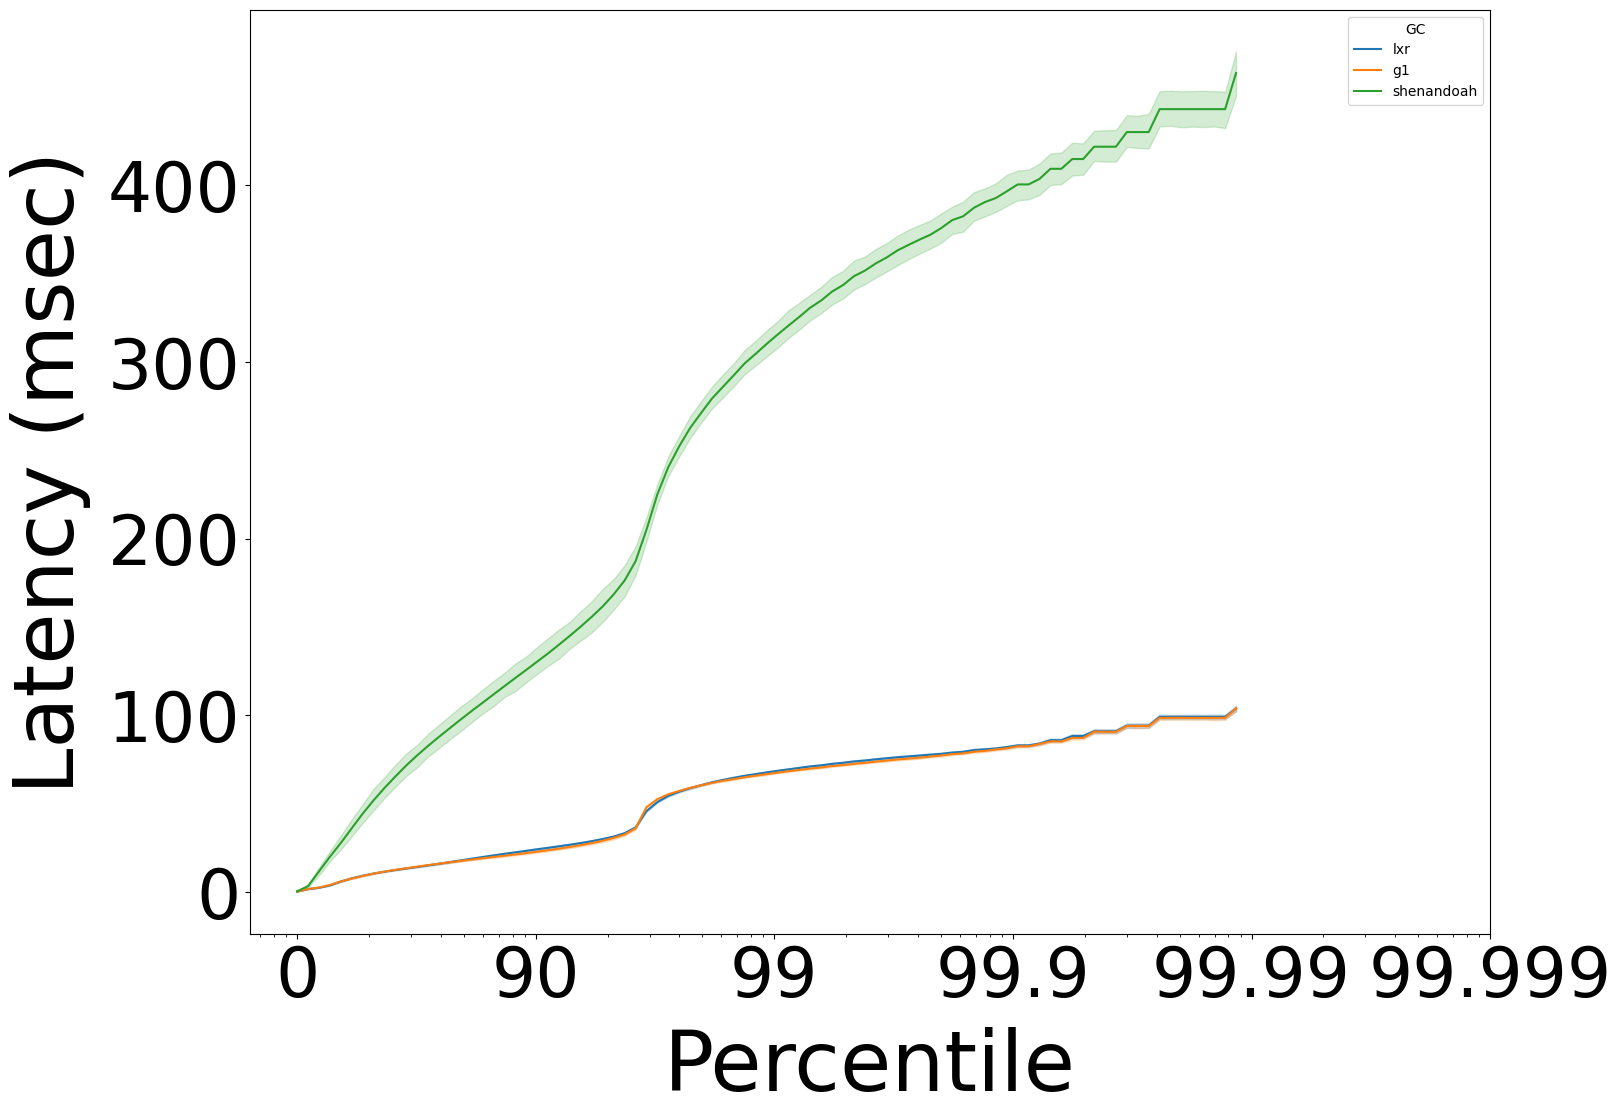

In [7]:
load_data_and_plot(bench='spring', legend='upper left')

[tradesoap] Loading ...
[tradesoap] Loading histograms from 123 folders ...
[tradesoap] Processing 119 histograms ...
       GC  inv  value  percentile
0     lxr    0      8    0.000000
1     lxr    0     25    0.100000
2     lxr    0     37    0.190000
3     lxr    0    324    0.271000
4     lxr    0    843    0.343900
...   ...  ...    ...         ...
9753   g1   39  68823    0.999700
9754   g1   39  68823    0.999730
9755   g1   39  68823    0.999757
9756   g1   39  72495    0.999782
9757   g1   39  72495    1.000000

[9758 rows x 4 columns]
[tradesoap] Plotting ...


IndexError: list index out of range

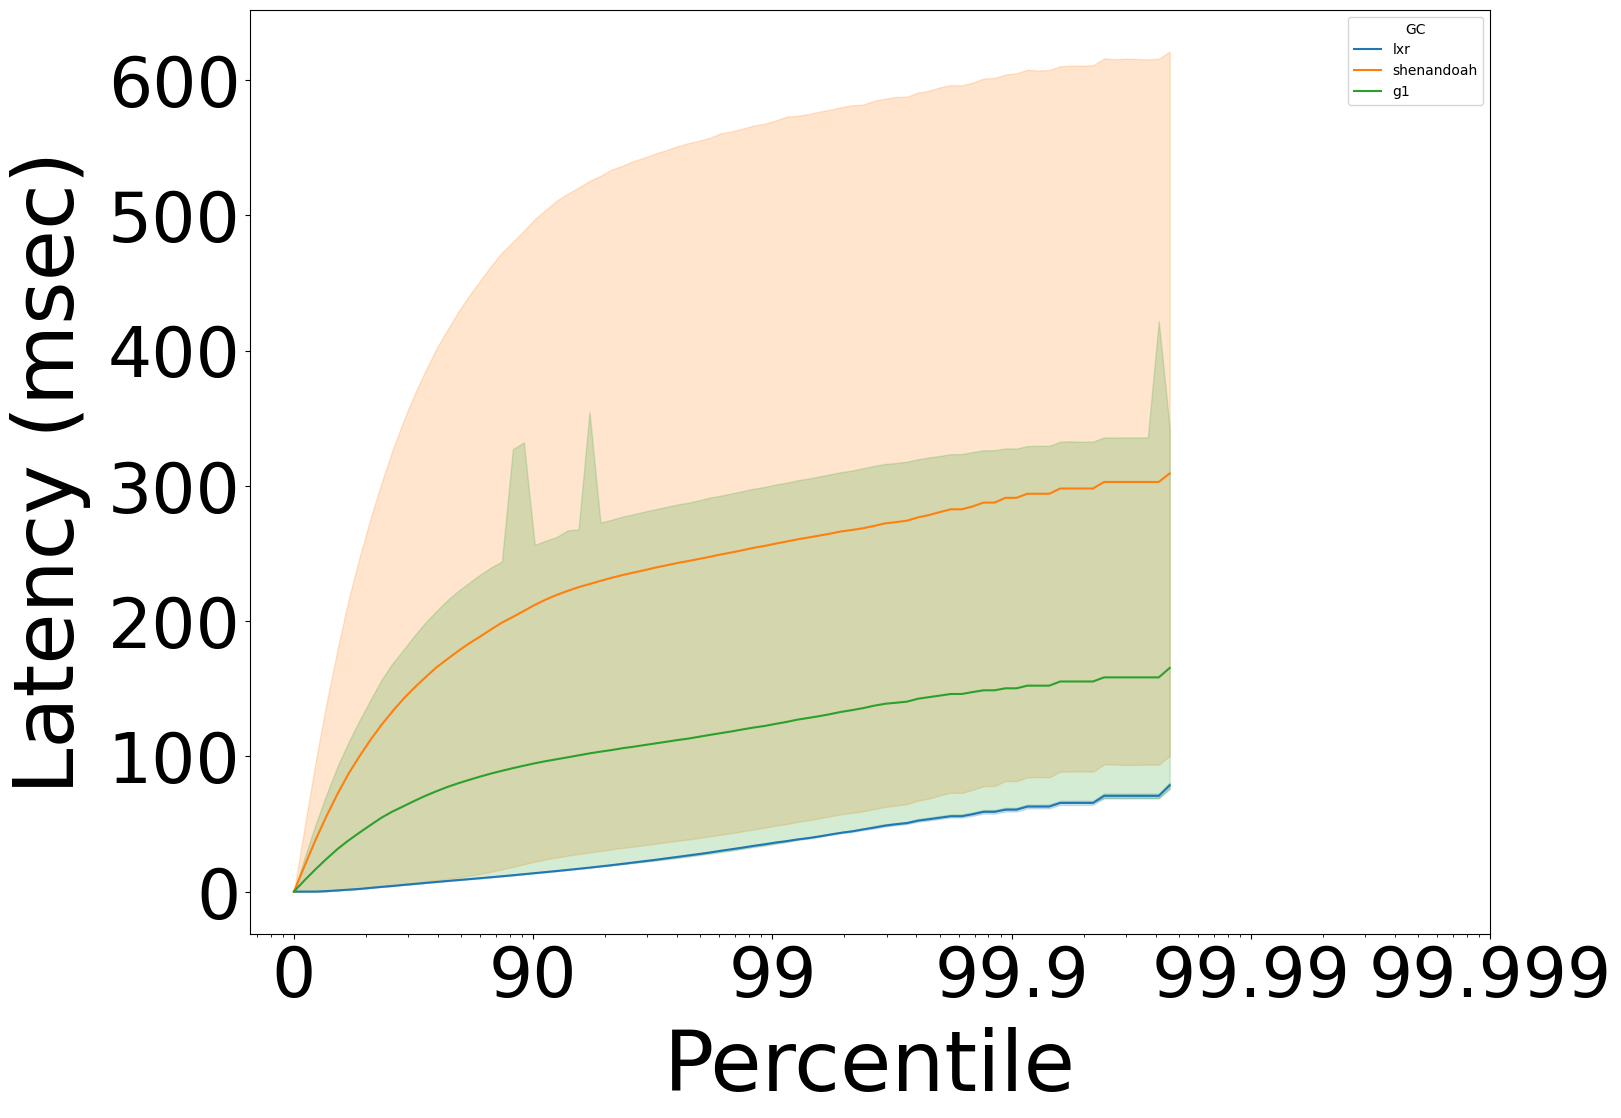

In [10]:
load_data_and_plot(bench='tradesoap', legend='upper left')

[tradebeans] Loading ...
[tradebeans] Loading histograms from 124 folders ...
[tradebeans] Processing 120 histograms ...
               GC  inv  value  percentile
0             lxr    0      3    0.000000
1             lxr    0     18    0.100000
2             lxr    0     39    0.190000
3             lxr    0    108    0.271000
4             lxr    0    564    0.343900
...           ...  ...    ...         ...
11515  shenandoah   39  80907    0.999931
11516  shenandoah   39  80907    0.999938
11517  shenandoah   39  80907    0.999944
11518  shenandoah   39  88747    0.999950
11519  shenandoah   39  88747    1.000000

[11520 rows x 4 columns]
[tradebeans] Plotting ...


IndexError: list index out of range

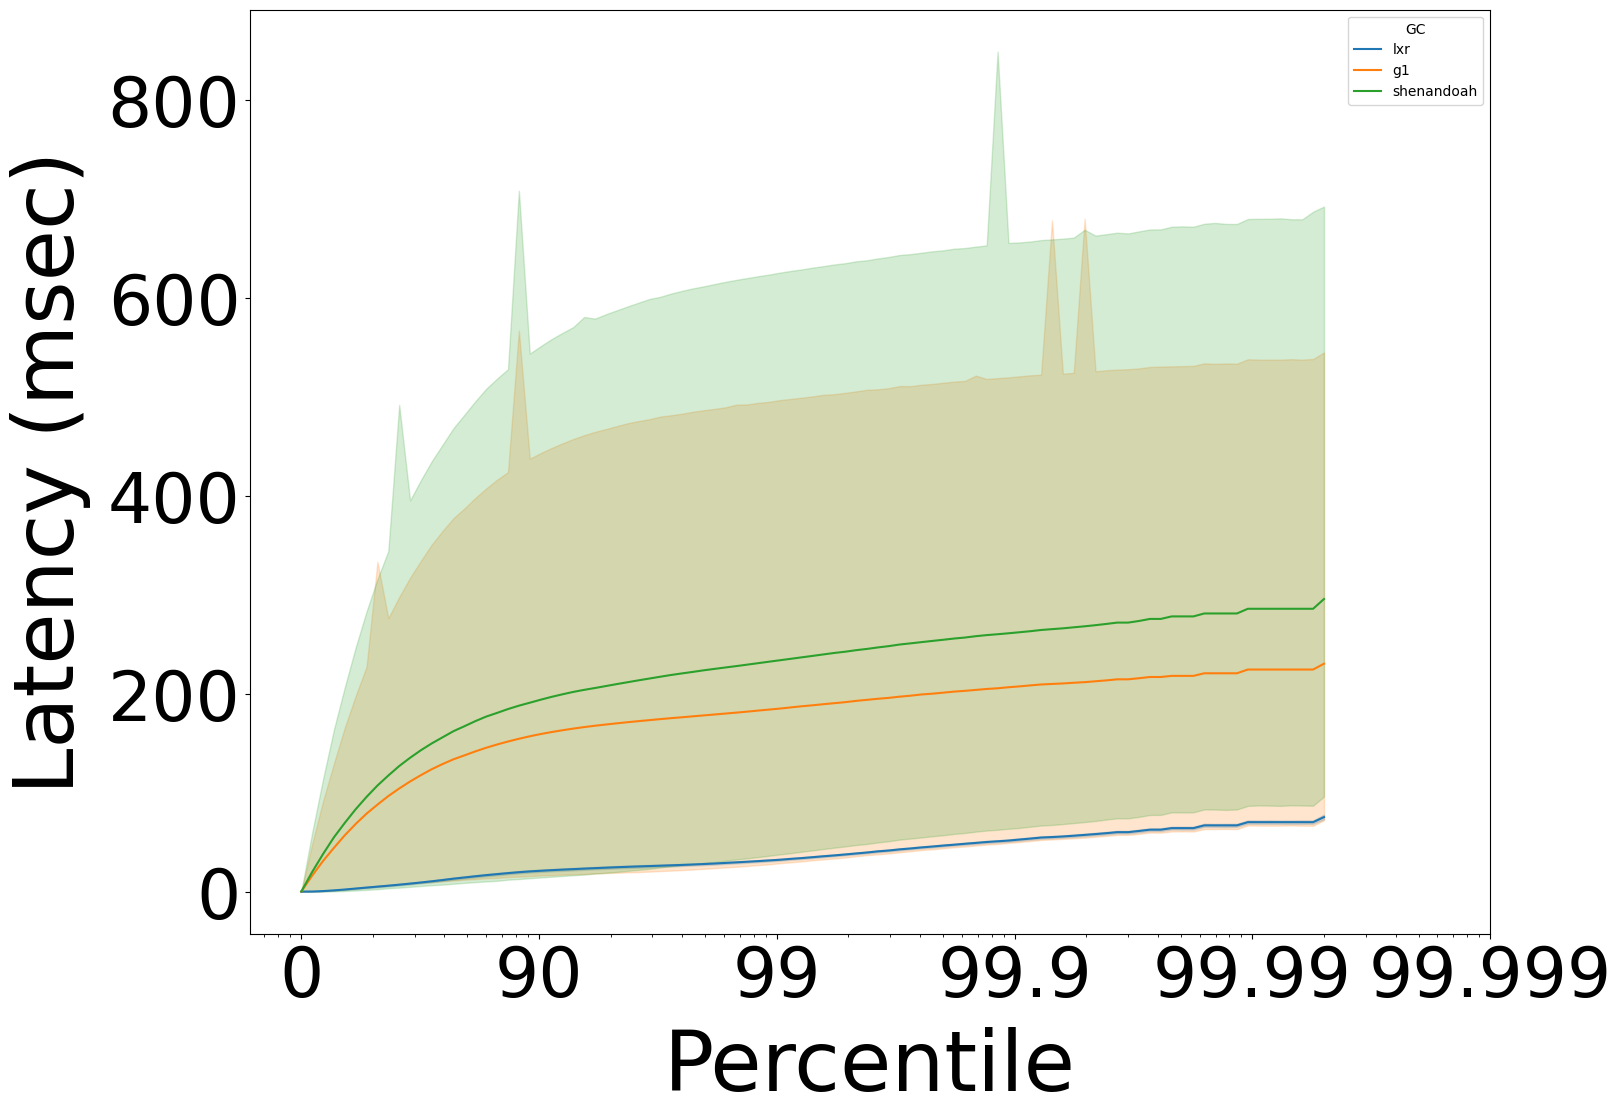

In [9]:
load_data_and_plot(bench='tradebeans', legend='upper left')

[tomcat] Loading ...
[tomcat] Loading histograms from 123 folders ...
[tomcat] Processing 119 histograms ...
               GC  inv   value  percentile
0             lxr    0     154    0.000000
1             lxr    0    1221    0.100000
2             lxr    0    1763    0.190000
3             lxr    0    9565    0.271000
4             lxr    0   17669    0.343900
...           ...  ...     ...         ...
13085  shenandoah   38  174639    0.999984
13086  shenandoah   38  174639    0.999986
13087  shenandoah   38  174639    0.999987
13088  shenandoah   38  176127    0.999989
13089  shenandoah   38  176127    1.000000

[13090 rows x 4 columns]
[tomcat] Plotting ...


IndexError: list index out of range

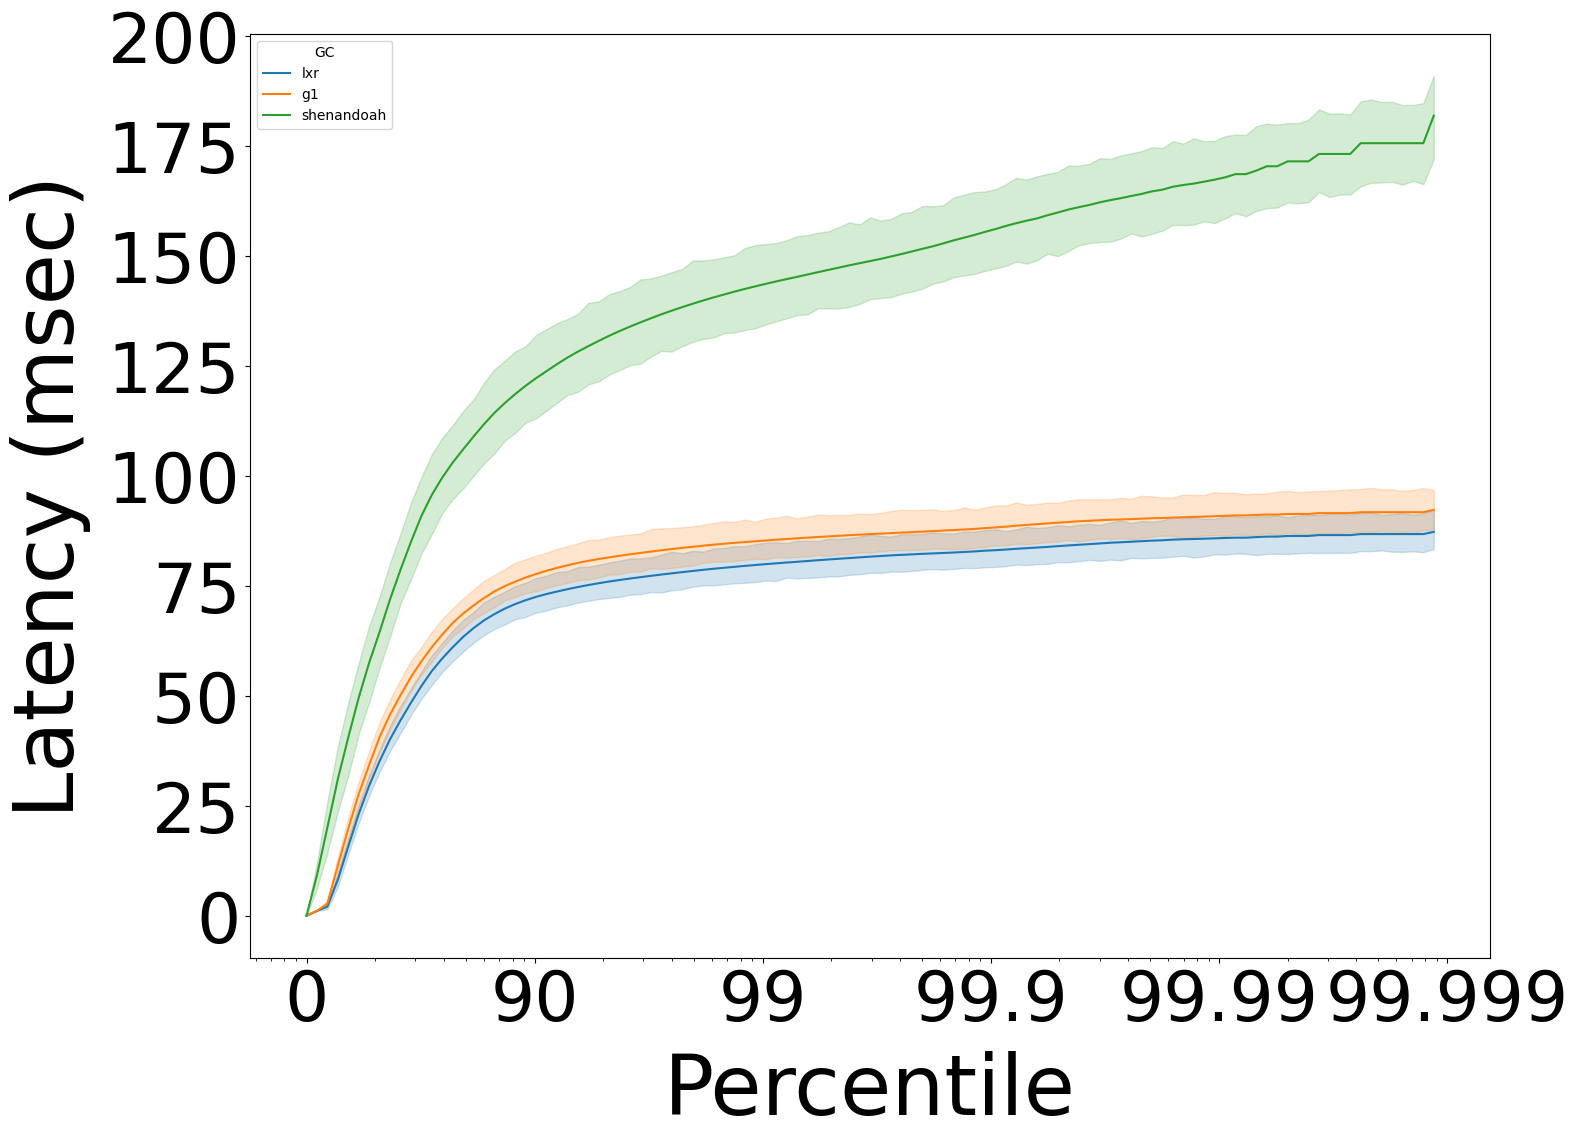

In [8]:
load_data_and_plot(bench='tomcat', legend='upper left')

In [ ]:
latency_sns_common = {
    "hue_order": ["Serial", "Parallel", "G1", "Shenandoah", "Z", "GenZ"],
    "palette": ["#000000", "#8e00ff", "#417be4", "#ff8e00", "#ff0000", "#db4b93"],
    "hue": "_hotspot_gc",
}


def latency_legend_annotate(ax: matplotlib.axes.Axes, use_year: bool, legend_kwargs):
    if use_year:
        renaming_map = dict(
            zip(
                ["Serial", "Parallel", "G1", "Shenandoah", "Z", "GenZ"],
                [
                    "1998 Serial",
                    "2005 Parallel",
                    "2009 G1",
                    "2014 Shen.",
                    "2018 ZGC",
                    "2023 GenZGC",
                ],
            )
        )
    else:
        renaming_map = dict(
            zip(
                ["Serial", "Parallel", "G1", "Shenandoah", "Z", "GenZ"],
                [
                    "Serial",
                    "Parallel",
                    "G1",
                    "Shen.",
                    "ZGC",
                    "GenZGC",
                ],
            )
        )
    lines = []
    labels = []
    for line in list(ax.get_lines()):
        if line.get_label() in renaming_map:
            lines.append(line)
            labels.append(renaming_map[line.get_label()])
    ax.legend(lines, labels, **legend_kwargs)


def draw_latency(df: pd.DataFrame):
    # lf = pl.scan_parquet(
    #     "../data/dacapo-pldi-2024-latency-vole-2023-11-12-Sun-235729/parsed_latency.parquet"
    # )
    # df = (
    #     lf.filter(pl.col("_iteration") == 4, pl.col("reciprocal").is_finite())
    #     .with_columns(pl.col("value") / 1000000)  # ns -> ms
    #     .collect()
    # )
    for (bm, hfac, latency_type), bm_df in df.group_by(
        "_benchmark", "_hfac", "_latency_type"
    ):
        fig, ax = plt.subplots(figsize=(5, 3))
        sns.lineplot(data=bm_df, x="reciprocal", y="value", ax=ax, **latency_sns_common)
        ax.set_xscale("log")
        ax.set_yscale("log")
        xticks = [1, 10, 100, 1000, 10000, 100000, 1000000]
        xlabels = ["0", "90", "99", "99.9", "99.99", "99.999", "99.9999"]
        max_x = bm_df.select("reciprocal").max().item()
        for i, xtick in enumerate(xticks):
            if xtick > max_x:
                xticks = xticks[: i + 1]
                xlabels = xlabels[: i + 1]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)
        ax.set_xlabel("Percentile")
        ax.set_ylabel("Request latency (ms)")
        round_off_axes(ax)
        latency_legend_annotate(
            ax, True, legend_kwargs={"frameon": False, "fontsize": 11, "loc": "best"}
        )
        fig.savefig(
            "../figs/latency/{}_{}_{}.pdf".format(bm, latency_type, hfac),
            bbox_inches="tight",
        )
        latency_legend_annotate(
            ax, False, legend_kwargs={"frameon": False, "fontsize": 11, "loc": "best"}
        )
        fig.savefig(
            "../figs/latency/{}_{}_{}_noyear.pdf".format(bm, latency_type, hfac),
            bbox_inches="tight",
        )
        ax.get_legend().remove()
        fig.savefig(
            "../figs/latency/{}_{}_{}_nolegend.pdf".format(bm, latency_type, hfac),
            bbox_inches="tight",
        )
        plt.close()


[kafka] Loading ...
[kafka] Loading histograms from 151 folders ...
[kafka] Processing 147 histograms ...
               GC  inv  value  percentile
0      shenandoah    0    301    0.000000
1      shenandoah    0   3727    0.100000
2      shenandoah    0   4542    0.190000
3      shenandoah    0   5225    0.271000
4      shenandoah    0   5687    0.343900
...           ...  ...    ...         ...
19495          g1   39  79271    0.999997
19496          g1   39  79271    0.999998
19497          g1   39  79271    0.999998
19498          g1   39  79279    0.999998
19499          g1   39  79279    1.000000

[19500 rows x 4 columns]
[kafka] Plotting ...
[kafka] Save to latency-kafka.pdf


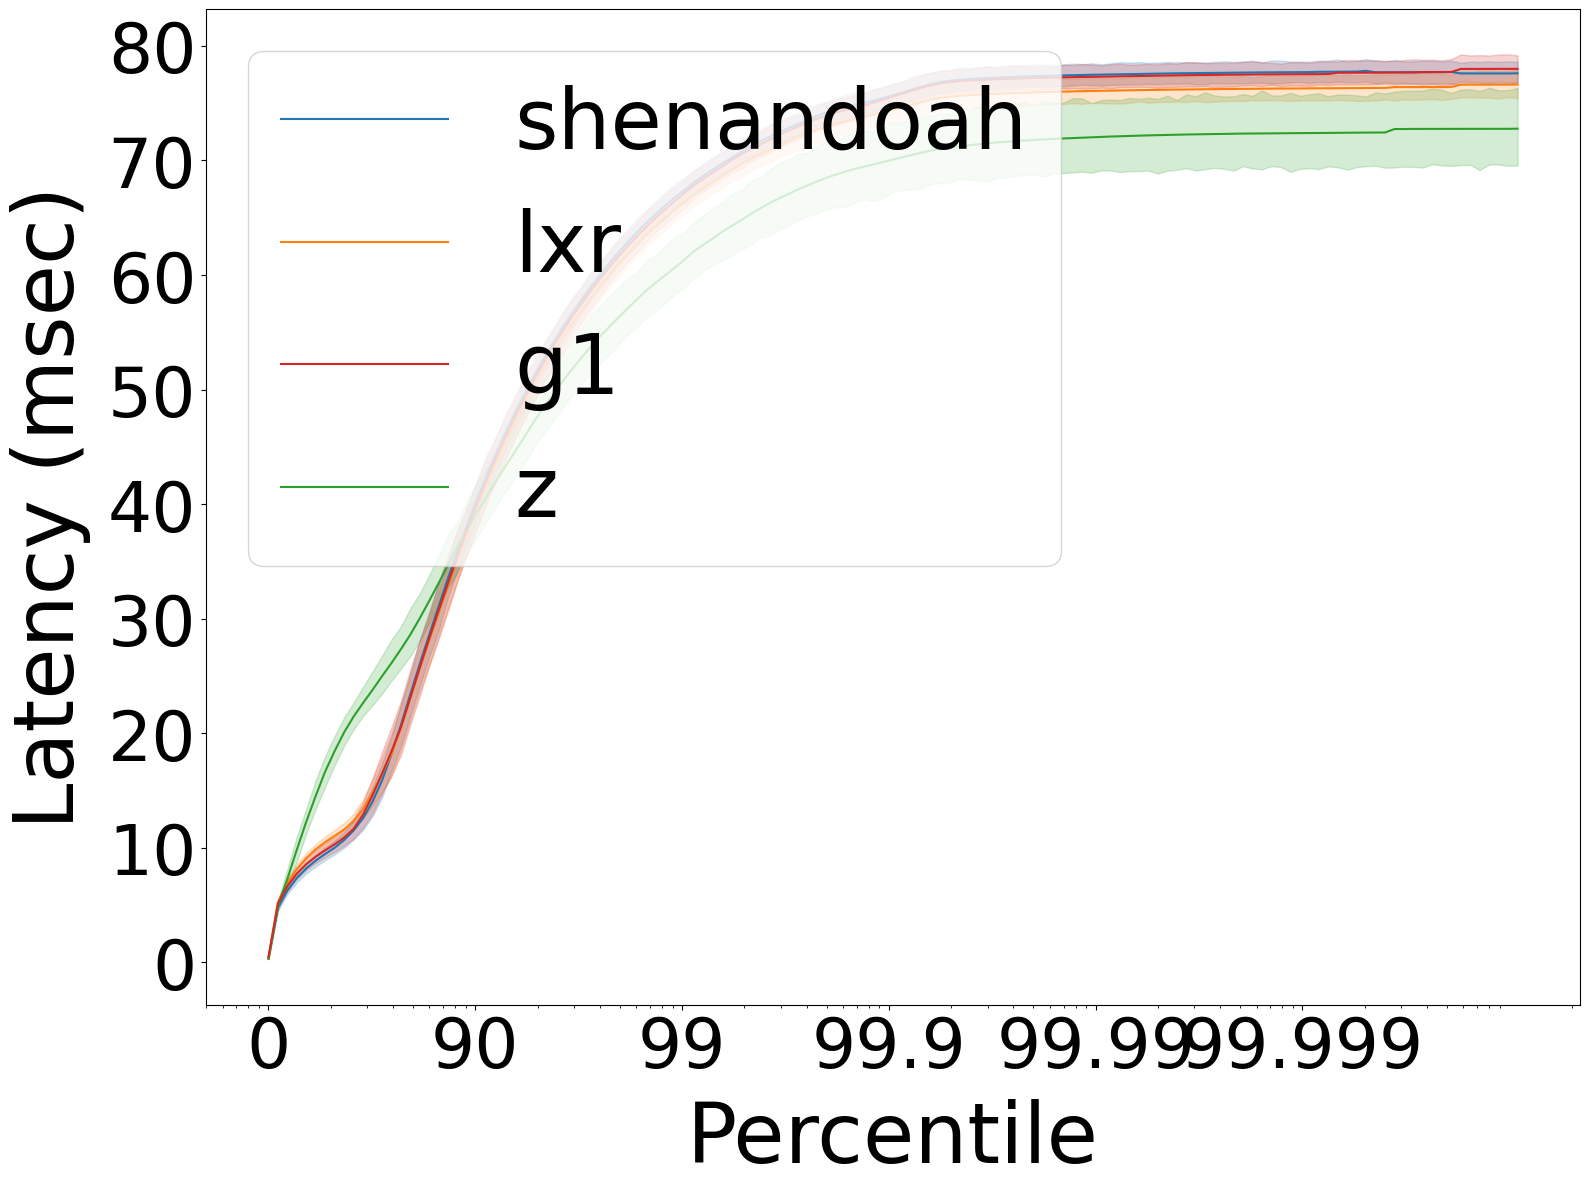

In [11]:
load_data_and_plot(bench='kafka', legend='upper left')